In [15]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('order_items.csv', 'orders_items')# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='reebok292000',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = '/Users/atharvavibhute/Desktop/Ecommerce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing order_items.csv
NaN values before replacement:
order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64



In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import mysql.connector
import seaborn as sns

# Connect to the MySQL database
db = mysql.connector.connect(
    host='localhost',
    user='root',
    password='reebok292000',
    database='ecommerce'
)

cur = db.cursor()

Matplotlib is building the font cache; this may take a moment.


# List all unique cities where customers are located.

In [53]:
query = """ select distinct (customer_city) from customers"""
cur.execute(query)
data = cur.fetchall()
#data
df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017.

In [23]:
query = """select count(order_id) from orders where order_purchase_timestamp like '%2017%'"""
cur.execute(query)
data = cur.fetchall()
data

[(45101,)]

# Find the total sales per category.

In [31]:
query = """select products.product_category , round(sum(payments.payment_value),2) 
from products inner join orders_items 
on products.product_id = orders_items.product_id
inner join payments on payments.order_id = orders_items.order_id
group by products.product_category"""
cur.execute(query)
data = cur.fetchall()
#data

df = pd.DataFrame(data,columns= ['Category','Sales'])
df


,Category,Sales
0,perfumery,506738.66
1,Furniture Decoration,1430176.39
2,telephony,486882.05
3,Fashion Bags and Accessories,218158.28
4,bed table bath,1712553.67
...,...,...
69,cds music dvds,1199.43
70,La Cuisine,2913.53
71,Fashion Children's Clothing,785.67
72,PC Gamer,2174.43


# Calculate the percentage of orders that were paid in installments.

In [35]:
query = """select (sum(case when payment_installments >= 1 then 1 
else 0 end))/count(*)*100 from payments"""
cur.execute(query)
data = cur.fetchall()
data

[(Decimal('99.9981'),)]

# Count the number of customers from each state. 

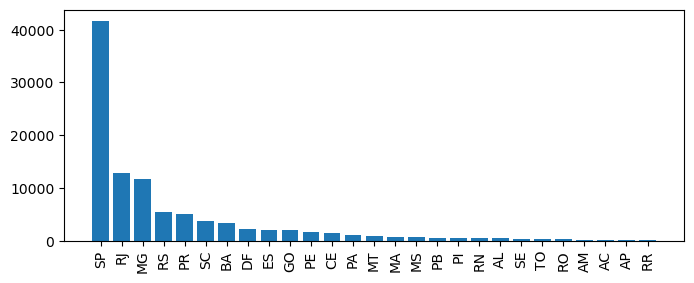

In [65]:
query = """select customer_state,count(customer_id) from customers group by customer_state"""
cur.execute(query)
data = cur.fetchall()
#data

df = pd.DataFrame(data,columns = ['State','Number of Customers'])
df = df.sort_values(by = 'Number of Customers',ascending = False)
#df
plt.figure(figsize = (8,3))
plt.bar(df['State'],df['Number of Customers'])
plt.xticks(rotation = 90)
plt.show()


# Calculate the number of orders per month in 2018.

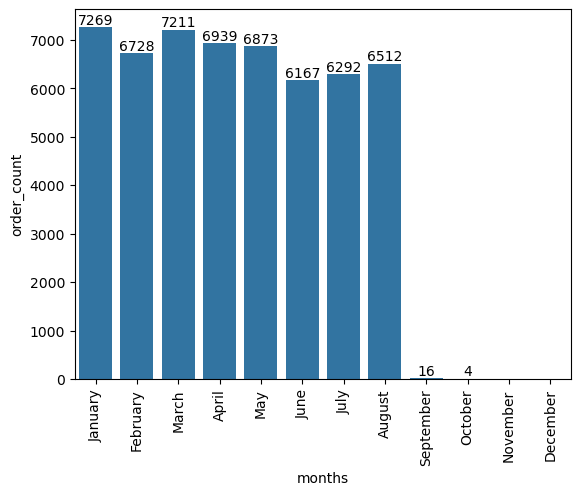

In [79]:
query = """select monthname(order_purchase_timestamp) months, count(order_id) order_count 
from orders where year(order_purchase_timestamp) = 2018
group by months"""
cur.execute(query)
data = cur.fetchall()
#data
df = pd.DataFrame(data,columns = ['months','order_count'])
o = ["January","February","March","April","May","June","July","August","September","October","November","December"]
ax = sns.barplot(x = df["months"], y = df["order_count"],data = df,order = o)
plt.xticks(rotation = 90)
ax.bar_label(ax.containers[0])
plt.show()

# Find the average number of products per order, grouped by customer city.

In [83]:
query = """with count_per_order as
(select o.order_id,o.customer_id,count(oi.order_id) oc from orders o 
inner join orders_items oi on o.order_id = oi.order_id 
group by o.order_id, o.customer_id)

select c.customer_city, round(avg(cpo.oc),2) average_orders from customers c inner join count_per_order cpo
on c.customer_id = cpo.customer_id
group by c.customer_city"""
cur.execute(query)
data = cur.fetchall()
#data
df = pd.DataFrame(data)
df

,0,1
0,sao jose dos campos,1.14
1,indaial,1.12
2,treze tilias,1.27
3,sao paulo,1.16
4,rio de janeiro,1.15
...,...,...
4105,buriti,3.00
4106,morro agudo de goias,1.00
4107,santa filomena,1.00
4108,guamiranga,1.00


# Calculate the percentage of total revenue contributed by each product category.


In [87]:
query = """select upper(products.product_category) category, round((sum(payments.payment_value) / (select sum(payment_value) from payments)) * 100,2) sales_percentage
from products inner join orders_items 
on products.product_id = orders_items.product_id
inner join payments on payments.order_id = orders_items.order_id
group by products.product_category
order by sales_percentage desc"""
cur.execute(query)
data = cur.fetchall()
data


[('BED TABLE BATH', 10.7),
 ('HEALTH BEAUTY', 10.35),
 ('COMPUTER ACCESSORIES', 9.9),
 ('FURNITURE DECORATION', 8.93),
 ('WATCHES PRESENT', 8.93),
 ('SPORT LEISURE', 8.7),
 ('HOUSEWARES', 6.84),
 ('AUTOMOTIVE', 5.32),
 ('GARDEN TOOLS', 5.24),
 ('COOL STUFF', 4.87),
 ('FURNITURE OFFICE', 4.04),
 ('TOYS', 3.87),
 ('BABIES', 3.37),
 ('PERFUMERY', 3.17),
 ('TELEPHONY', 3.04),
 ('STATIONARY STORE', 1.98),
 ('PET SHOP', 1.94),
 ('PCS', 1.74),
 ('ELECTRONICS', 1.62),
 (None, 1.58),
 ('CONSTRUCTION TOOLS CONSTRUCTION', 1.51),
 ('MUSICAL INSTRUMENTS', 1.46),
 ('ELECTROSTILE', 1.41),
 ('FASHION BAGS AND ACCESSORIES', 1.36),
 ('FIXED TELEPHONY', 1.29),
 ('GAMES CONSOLES', 1.22),
 ('BAGS ACCESSORIES', 1.17),
 ('CASA CONSTRUCAO', 0.85),
 ('ROOM FURNITURE', 0.85),
 ('ELECTRICES 2', 0.78),
 ('AGRO INDUSTRIA E COMERCIO', 0.74),
 ('HOME APPLIANCES', 0.6),
 ('CLIMATIZATION', 0.57),
 ('HOUSE COMFORT', 0.53),
 ('FURNITURE KITCHEN SERVICE AREA DINNER AND GARDEN', 0.47),
 ('DRINKS', 0.45),
 ('CONSTRUCTION T

# Identify the correlation between product price and the number of times a product has been purchased.

In [95]:
import numpy as np

query = """select p.product_category, count(oi.order_id), round(avg(price),2) from products p 
join orders_items oi on p.product_id = oi.product_id 
group by p.product_category"""

cur.execute(query)

data = cur.fetchall()
#data
df = pd.DataFrame(data,columns= ['Category','order_count','price'])
df

arr1 = df["order_count"]
arr2 = df["price"]

np.corrcoef([arr1,arr2])

array([[ 1.        , -0.10631514],
       [-0.10631514,  1.        ]])

In [93]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


# Calculate the total revenue generated by each seller, and rank them by revenue.

In [158]:
query = """select *, dense_rank() over(order by revenue desc) as rn from
(select oi.seller_id, sum(p.payment_value) revenue from orders_items oi 
inner join payments p on oi.order_id = p.order_id
group by oi.seller_id) as a"""

cur.execute(query)

data = cur.fetchall()
#data
df = pd.DataFrame(data)
df.head()

,0,1,2
0,7c67e1448b00f6e969d365cea6b010ab,507166.907302,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,308222.039840,2
2,4a3ca9315b744ce9f8e9374361493884,301245.269765,3
3,1f50f920176fa81dab994f9023523100,290253.420128,4
4,53243585a1d6dc2643021fd1853d8905,284903.080498,5


# Calculate the moving average of order values for each customer over their order history.

In [122]:
query = """select customer_id, order_purchase_timestamp,payment_value,avg(payment_value)
over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select o.customer_id,o.order_purchase_timestamp,p.payment_value from orders o 
inner join payments p on o.order_id = p.order_id) as a;"""

cur.execute(query)

data = cur.fetchall()
#data
df = pd.DataFrame(data,columns= ['Customer_id','order_timestamp','price','mov_avg'])
df

,Customer_id,order_timestamp,price,mov_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,0.64,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000


# Calculate the cumulative sales per month for each year.

In [125]:
query = """select years,months, payment,sum(payment) over(order by years, months) as cummulative_sales
from
(select year(o.order_purchase_timestamp) as years,
month(o.order_purchase_timestamp) as months,round(sum(p.payment_value),2) as payment
 from orders o inner join payments p 
 on o.order_id = p.order_id
 group by years,months
 order by years,months) as a;"""

cur.execute(query)

data = cur.fetchall()
data

[(2016, 9, 252.24, 252.24),
 (2016, 10, 59090.48, 59342.72),
 (2016, 12, 19.62, 59362.340000000004),
 (2017, 1, 138488.04, 197850.38),
 (2017, 2, 291908.01, 489758.39),
 (2017, 3, 449863.6, 939621.99),
 (2017, 4, 417788.03, 1357410.02),
 (2017, 5, 592918.82, 1950328.8399999999),
 (2017, 6, 511276.38, 2461605.2199999997),
 (2017, 7, 592382.92, 3053988.1399999997),
 (2017, 8, 674396.32, 3728384.4599999995),
 (2017, 9, 727762.45, 4456146.909999999),
 (2017, 10, 779677.88, 5235824.789999999),
 (2017, 11, 1194882.8, 6430707.589999999),
 (2017, 12, 878401.48, 7309109.069999998),
 (2018, 1, 1115004.18, 8424113.249999998),
 (2018, 2, 992463.34, 9416576.589999998),
 (2018, 3, 1159652.12, 10576228.709999997),
 (2018, 4, 1160785.48, 11737014.189999998),
 (2018, 5, 1153982.15, 12890996.339999998),
 (2018, 6, 1023880.5, 13914876.839999998),
 (2018, 7, 1066540.75, 14981417.589999998),
 (2018, 8, 1022425.32, 16003842.909999998),
 (2018, 9, 4439.54, 16008282.449999997),
 (2018, 10, 589.67, 16008872.11

# Calculate the year-over-year growth rate of total sales.

In [136]:
query = """with a as(select year(o.order_purchase_timestamp) as years,round(sum(p.payment_value),2) as payment
 from orders o inner join payments p 
 on o.order_id = p.order_id
 group by years
 order by years)

 select years,((payment - lag(payment, 1) over(order by years))/ lag(payment, 1) over(order by years)) * 100 from a
 """

cur.execute(query)

data = cur.fetchall()
#data
df = pd.DataFrame(data,columns= ['Year','yoy % growth'])
df


,Year,yoy
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [139]:
query = """with a as(select c.customer_id, min(o.order_purchase_timestamp) first_order
from customers c inner join orders o 
on c.customer_id = o.customer_id
group by c.customer_id),

b as (select a.customer_id, count(distinct o.order_purchase_timestamp)
from a join orders o on a.customer_id = o.customer_id
and o.order_purchase_timestamp > a.first_order
and o.order_purchase_timestamp < date_add(first_order, interval 6 month)
group by a.customer_id)

select 100 * ((count( distinct a.customer_id))/(count( distinct b.customer_id)))
from a left join b on a.customer_id = b.customer_id
;"""

cur.execute(query)

data = cur.fetchall()
data
# Since none of the customers are repeated so null value is coming

[(None,)]

# Identify the top 3 customers who spent the most money in each year.

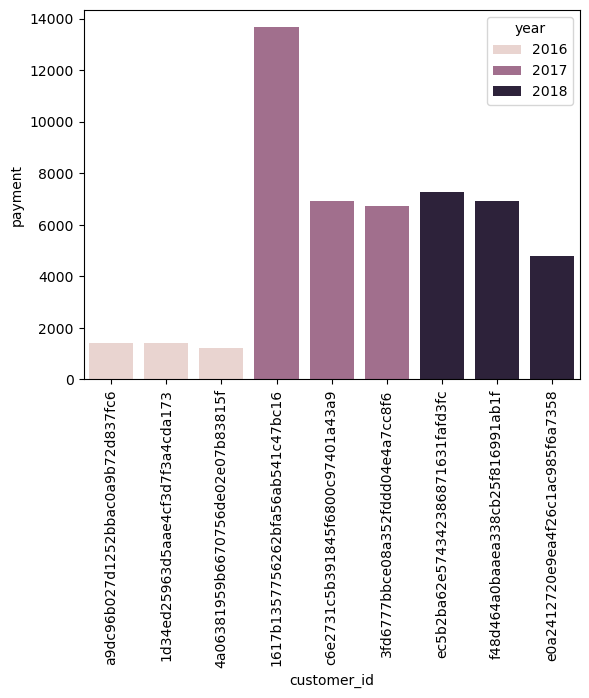

In [156]:
query = """select years, customer_id,payment,_rank
from
(select year(o.order_purchase_timestamp) years,o.customer_id, sum(p.payment_value) payment,
dense_rank()over(partition by year(o.order_purchase_timestamp)
order by sum(p.payment_value)desc) _rank
 from orders o 
inner join payments p on o.order_id = p.order_id
group by year(o.order_purchase_timestamp),o.customer_id) as a
where _rank <= 3;
"""

cur.execute(query)

data = cur.fetchall()

#data

df = pd.DataFrame(data,columns = ['year','customer_id','payment','rank'])
#df
sns.barplot(x = 'customer_id',y='payment',data= df, hue = 'year')
plt.xticks(rotation = 90)
plt.show()